In [1]:
import pandas as pd
import gc

In [2]:
df = pd.read_parquet("/workspace/resources/input/task1_dataset_raw_train.parquet")

In [3]:
test_uids = df.loc[df["x"] == 999, "uid"].unique()
df = df[~df["uid"].isin(test_uids)].reset_index(drop=True)
uids = df["uid"].unique()
df = df[df["uid"].isin(uids[:10000])]

In [4]:
tr_uids = uids[:5000]
va_uids = uids[5000:]

train_df = df[df["uid"].isin(tr_uids)].reset_index(drop=True)
valid_df = df[df["uid"].isin(va_uids)].reset_index(drop=True)
del df
gc.collect()

0

In [49]:
def assign_day_of_week(df):
    df["dayofweek"] = (df["d"] % 7).astype(int)
    df["weekend"] = df["dayofweek"].isin([6, 0])
    return df


def assign_t_labe(df):
    morning = {k: 0 for k in list(range(12, 36))}
    midnight = {k: 1 for k in list(range(36, 48)) + list(range(0, 12))}
    t_label_mapping = {**morning, **midnight}
    df["t_label"] = df["t"].map(t_label_mapping)
    return df

def assign_detailed_t_label(df):
    division = 48 // 12  # 48を12で割った値
    result_dict = {i: i // division for i in range(48)}
    df["detailed_t_label"] = df["t"].map(result_dict)
    return df
    

train_df = assign_day_of_week(train_df)
train_df = assign_t_labe(train_df)
train_df = assign_detailed_t_label(train_df)

valid_df = assign_day_of_week(valid_df)
valid_df = assign_t_labe(valid_df)
valid_df = assign_detailed_t_label(valid_df)

keys = [
    "uid", 
    "weekend", 
    "t",
    ]
agg_df = train_df.query("d < 60").groupby(keys)[["x", "y"]].agg("mean").reset_index().rename(columns={"x":"agg_x", "y":"agg_y"})
if "agg_x" in train_df.columns:
    train_df.drop("agg_x", axis=1, inplace=True)
    train_df.drop("agg_y", axis=1, inplace=True)
train_df = pd.merge(train_df, agg_df, on=keys, how="left")
train_df.head()

,uid,d,t,x,y,dayofweek,weekend,t_label,detailed_t_label,color_condition,time,agg_x,agg_y
0,0,0,1,79,86,0,True,1,0,False,1,80.666667,87.666667
1,0,0,2,79,86,0,True,1,0,False,2,78.500000,86.000000
2,0,0,8,77,86,0,True,1,2,False,8,77.000000,86.000000
3,0,0,9,77,86,0,True,1,2,False,9,77.000000,86.000000
4,0,0,19,81,89,0,True,0,4,False,19,92.571429,88.428571


In [50]:
preds_df = train_df.query("d >= 60").dropna().reset_index(drop=True)
preds_df

,uid,d,t,x,y,dayofweek,weekend,t_label,detailed_t_label,color_condition,time,agg_x,agg_y
0,0,60,12,84,88,4,False,0,3,True,6012,82.956522,92.434783
1,0,60,13,96,70,4,False,0,3,True,6013,85.827586,90.517241
2,0,60,14,115,78,4,False,0,3,True,6014,91.178571,91.392857
3,0,60,15,114,78,4,False,0,3,True,6015,90.384615,90.307692
4,0,60,19,114,78,4,False,0,4,True,6019,85.812500,91.218750
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1242481,4999,74,23,129,81,4,False,0,5,True,7423,132.333333,69.000000
1242482,4999,74,24,138,75,4,False,0,6,True,7424,132.857143,75.285714
1242483,4999,74,25,150,73,4,False,0,6,True,7425,139.714286,76.857143
1242484,4999,74,43,149,70,4,False,1,10,True,7443,144.040000,71.280000


In [51]:
from sklearn.metrics import mean_squared_error
import geobleu
from tqdm import tqdm

In [52]:
reference = preds_df[["uid", "d", "t", "x", "y"]]
generated = preds_df[["uid", "d", "t", "agg_x", "agg_y"]].rename(columns={"agg_x":"x", "agg_y":"y"})

In [53]:
geobleu_score = 0
dtw_score = 0

eval_uids = reference["uid"].unique()[:100]
for uid in tqdm(eval_uids):
    a_generated = generated.loc[generated["uid"] == uid, ["d", "t", "x", "y"]].values.tolist()
    a_reference = reference.loc[reference["uid"] == uid, ["d", "t", "x", "y"]].values.tolist()
    
    geobleu_score += geobleu.calc_geobleu(a_generated, a_reference, processes=3)
    dtw_score += geobleu.calc_dtw(a_generated, a_reference, processes=3)

geobleu_score = geobleu_score / len(eval_uids)
dtw_score = dtw_score / len(eval_uids)

print(f"geobleu_score={geobleu_score}, dtw_score={dtw_score}")

rmse = mean_squared_error(y_true=reference[["x", "y"]].values, y_pred=generated[["x", "y"]].values, squared=False)
print(f"rmse={rmse}")

100%|██████████| 100/100 [00:21<00:00,  4.64it/s]


geobleu_score=0.1503528009896643, dtw_score=59.15418215645318
rmse=15.022119241274797


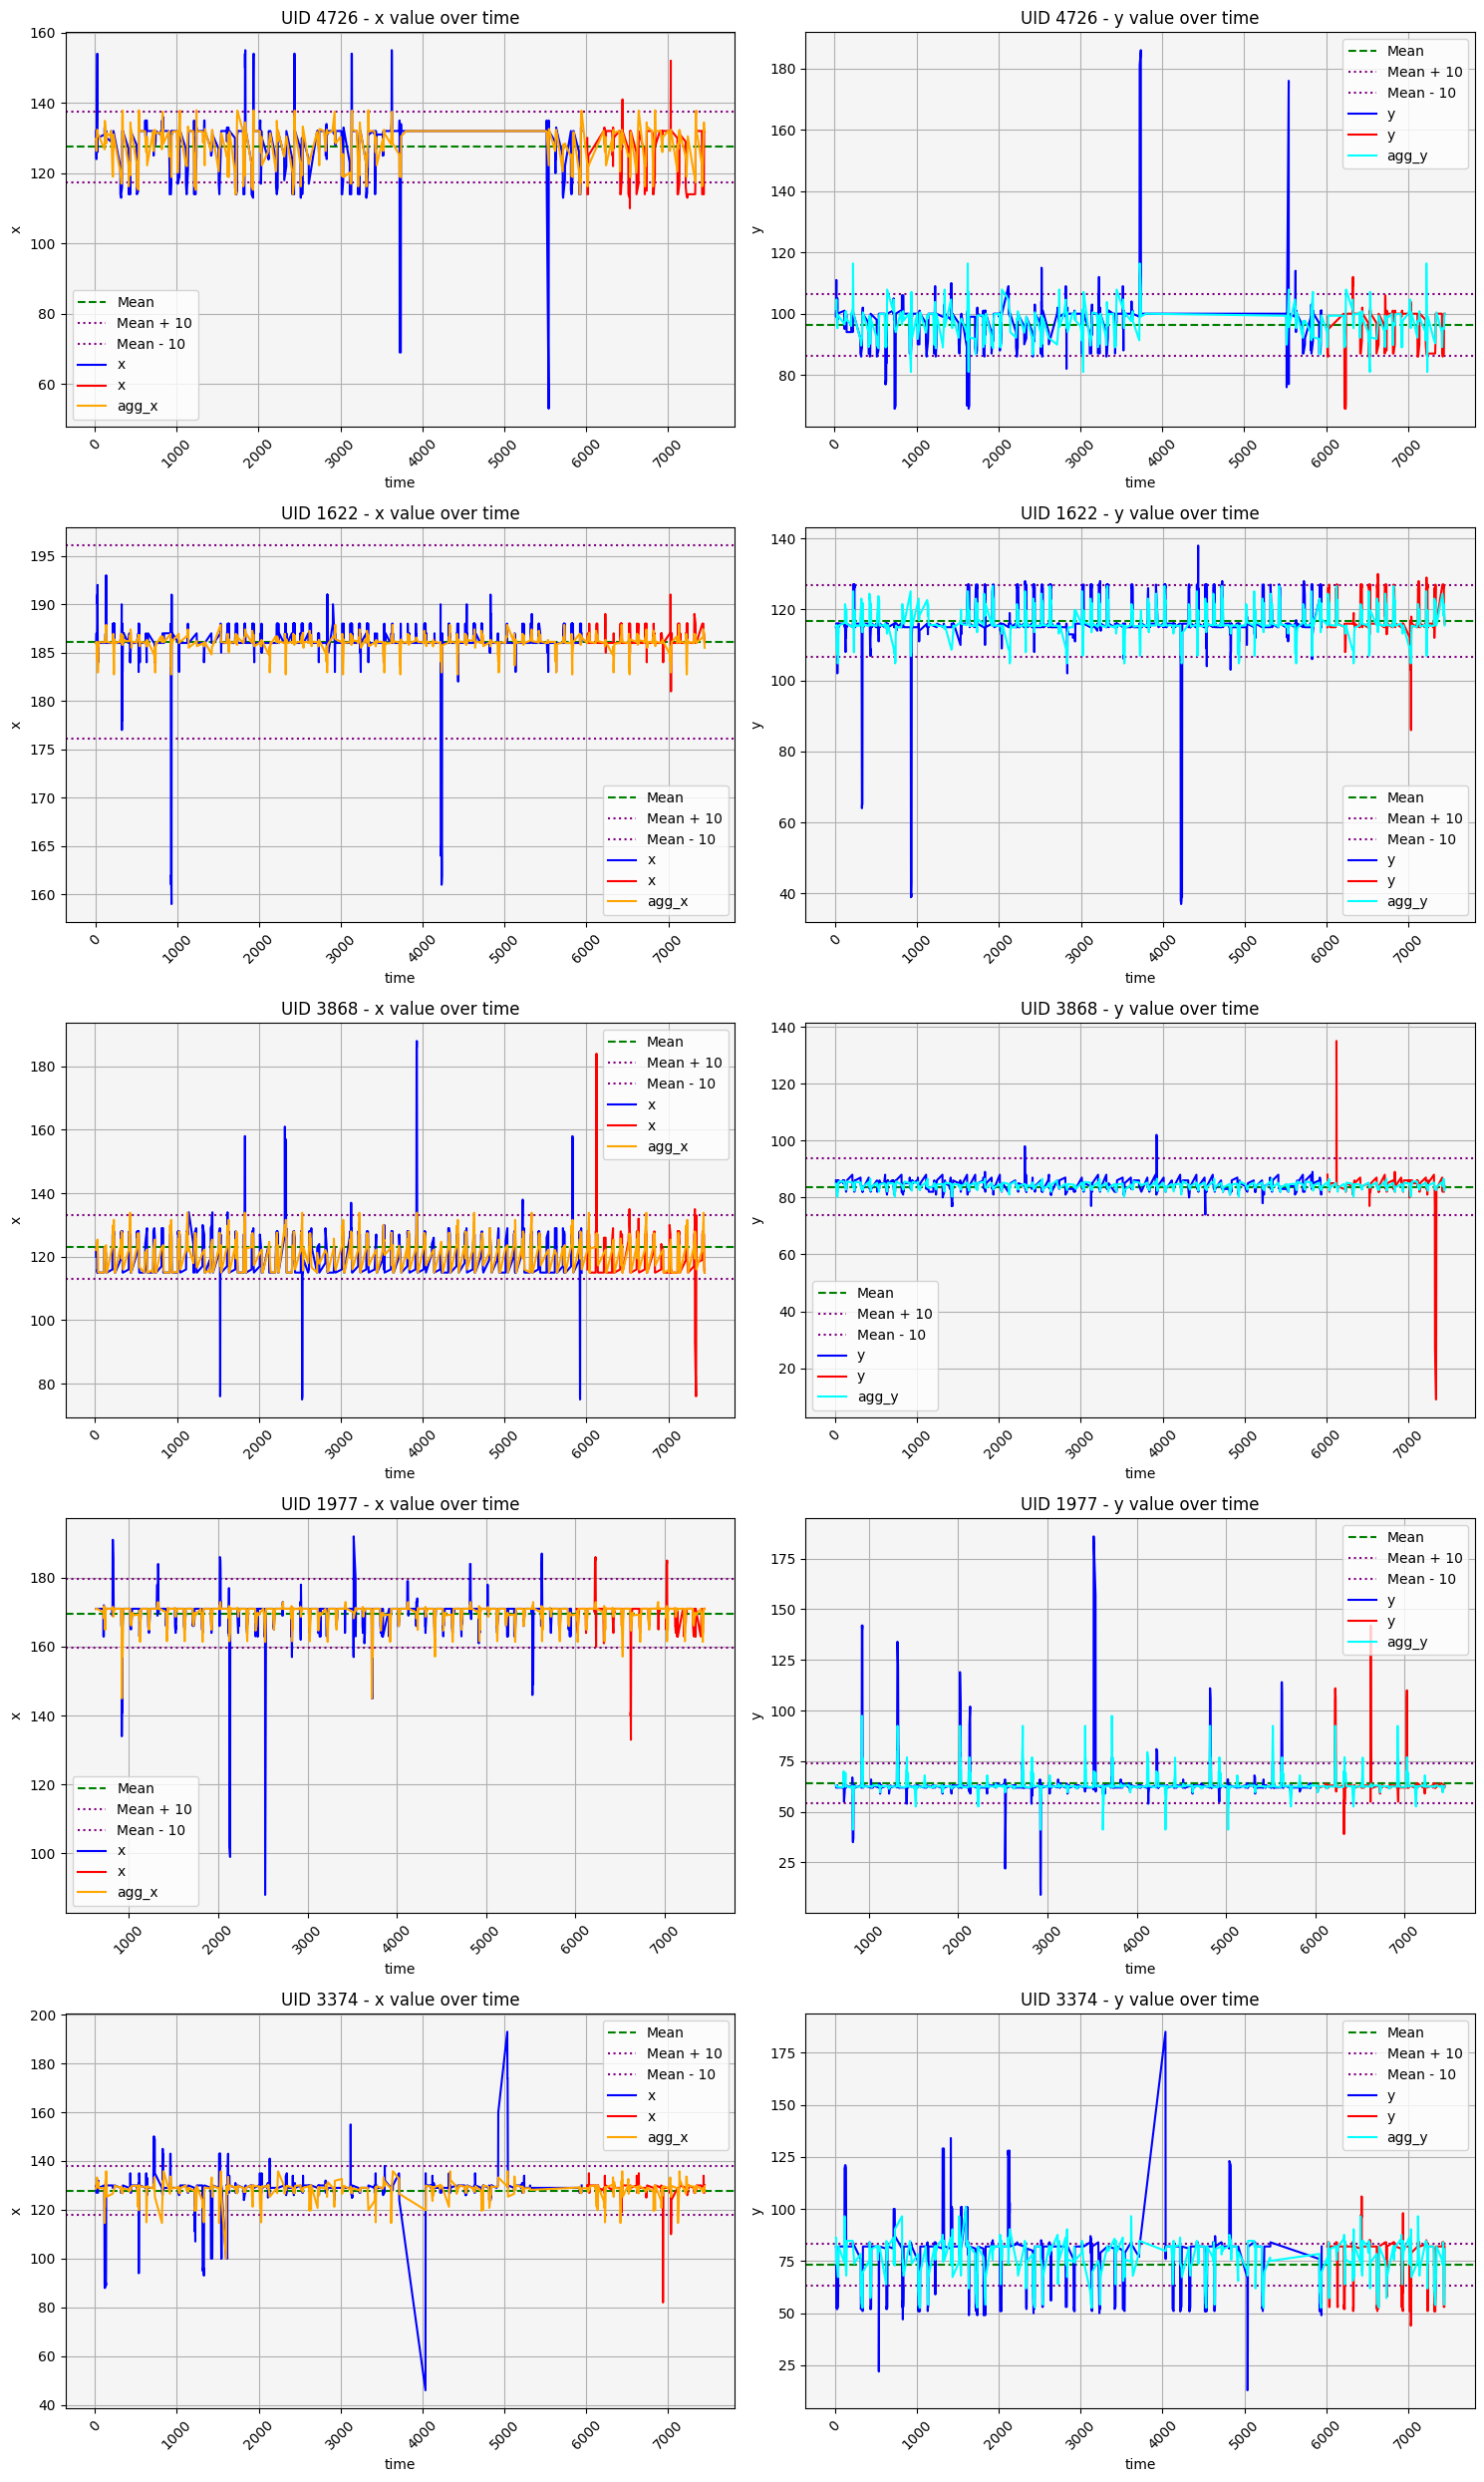

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_uid(df, uids):
    """
    df: DataFrame - 入力データ
    uids: list - グラフを出力したいuidのリスト
    """
        
    # d >= 60 の部分の色を変えるための列
    df['color_condition'] = df['d'] >= 60

    n_uids = len(uids)
    fig, axs = plt.subplots(n_uids, 2, figsize=(15, 5*n_uids))

    for i, uid in enumerate(uids):
        df_uid = df[df['uid'] == uid]

        for j, col in enumerate(['x', 'y']):
            mean_val = df_uid[col].mean()
            
            # 平均値の線
            axs[i, j].axhline(mean_val, color='green', linestyle='--', label='Mean')
            
            # 平均値±10の線
            axs[i, j].axhline(mean_val + 10, color='purple', linestyle=':', label='Mean + 10')
            axs[i, j].axhline(mean_val - 10, color='purple', linestyle=':', label='Mean - 10')
            
            sns.lineplot(x='time', y=col, hue='color_condition', data=df_uid, palette=["blue", "red"], ax=axs[i, j], legend=False, label=col)
            
            # agg_x または agg_y のデータを追加
            if col == 'x':
                sns.lineplot(x='time', y='agg_x', data=df_uid, color='orange', ax=axs[i, j], label='agg_x')
            else:
                sns.lineplot(x='time', y='agg_y', data=df_uid, color='cyan', ax=axs[i, j], label='agg_y')
            
            axs[i, j].set_title(f'UID {uid} - {col} value over time')
            axs[i, j].tick_params(axis='x', rotation=45)
            axs[i, j].grid(True)
            axs[i, j].set_facecolor("#f5f5f5")
            axs[i, j].legend()
    
    plt.tight_layout()
    plt.show()

train_df["time"] = (train_df["d"].astype(str).str.zfill(2) + train_df["t"].astype(str).str.zfill(2)).astype(int)
uids = pd.Series(train_df["uid"].unique()).sample(5, random_state=None)
plot_uid(train_df, uids)
